# Optuna Hyperparameter Optimization – Usage Guide

This notebook demonstrates how to use **Optuna** for hyperparameter optimization.

Optuna is a Bayesian hyperparameter optimization framework that intelligently searches the hyperparameter space.

## What is Optuna?

**Optuna** uses Tree-structured Parzen Estimator (TPE) to:
- Learn from past trials
- Intelligently sample hyperparameter space
- Find optimal parameters efficiently
- Support early stopping (pruning) of bad trials

## Setup

In [10]:
import sys
!{sys.executable} -m pip install optuna

In [11]:
import optuna
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

print('✓ Optuna version:', optuna.__version__)

✓ Optuna version: 4.6.0


## Example 1: Basic Optuna Usage with K-Means

This is the simplest Optuna workflow:
1. Define objective function
2. Create study
3. Optimize
4. Extract best parameters

In [12]:
# Create dummy data
np.random.seed(42)
X = np.random.randn(1000, 3)

print('Data shape:', X.shape)

# Define objective function
def objective_kmeans(trial):
    # Define hyperparameter search space
    n_clusters = trial.suggest_int('n_clusters', 2, 8)
    init = trial.suggest_categorical('init', ['k-means++', 'random'])
    n_init = trial.suggest_int('n_init', 5, 20)

    # Train model
    kmeans = KMeans(n_clusters=n_clusters, init=init, n_init=n_init, random_state=42)
    labels = kmeans.fit_predict(X)

    # Compute objective (silhouette score)
    score = silhouette_score(X, labels)
    return score

# Create study (container for optimization)
study = optuna.create_study(direction='maximize')

# Optimize (run 20 trials)
study.optimize(objective_kmeans, n_trials=20, show_progress_bar=True)

print(f'\n✓ Optimization Complete')
print(f'  Best value: {study.best_value:.4f}')
print(f'  Best params: {study.best_params}')

[I 2025-12-15 23:56:01,584] A new study created in memory with name: no-name-16aa9750-6da3-49f9-be01-6f7e29e09ef8


Data shape: (1000, 3)


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-15 23:56:01,711] Trial 0 finished with value: 0.2157203718860195 and parameters: {'n_clusters': 3, 'init': 'k-means++', 'n_init': 8}. Best is trial 0 with value: 0.2157203718860195.
[I 2025-12-15 23:56:01,925] Trial 1 finished with value: 0.22701664383619774 and parameters: {'n_clusters': 7, 'init': 'k-means++', 'n_init': 19}. Best is trial 1 with value: 0.22701664383619774.
[I 2025-12-15 23:56:02,082] Trial 2 finished with value: 0.2227456860439525 and parameters: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 16}. Best is trial 1 with value: 0.22701664383619774.
[I 2025-12-15 23:56:02,187] Trial 3 finished with value: 0.2140530061776777 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 6}. Best is trial 1 with value: 0.22701664383619774.
[I 2025-12-15 23:56:02,317] Trial 4 finished with value: 0.2140530061776777 and parameters: {'n_clusters': 3, 'init': 'random', 'n_init': 13}. Best is trial 1 with value: 0.22701664383619774.
[I 2025-12-15 23:56:02,461] Trial

## Example 2: Hierarchical Clustering with Optuna

In [13]:
# Define objective for Hierarchical Clustering
def objective_hierarchical(trial):
    n_clusters = trial.suggest_int('n_clusters', 2, 8)
    linkage = trial.suggest_categorical('linkage', ['ward', 'complete', 'average'])

    hac = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = hac.fit_predict(X)

    score = silhouette_score(X, labels)
    return score

# Create new study
study_hac = optuna.create_study(direction='maximize')

# Optimize
study_hac.optimize(objective_hierarchical, n_trials=20, show_progress_bar=True)

print(f'\n✓ Optimization Complete')
print(f'  Best value: {study_hac.best_value:.4f}')
print(f'  Best params: {study_hac.best_params}')

[I 2025-12-15 23:56:06,440] A new study created in memory with name: no-name-a689c2f4-d61e-414b-a416-4b5a9abc239e


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-15 23:56:06,551] Trial 0 finished with value: 0.16919338108317802 and parameters: {'n_clusters': 4, 'linkage': 'ward'}. Best is trial 0 with value: 0.16919338108317802.
[I 2025-12-15 23:56:06,696] Trial 1 finished with value: 0.16538904851137842 and parameters: {'n_clusters': 2, 'linkage': 'complete'}. Best is trial 0 with value: 0.16919338108317802.
[I 2025-12-15 23:56:06,837] Trial 2 finished with value: 0.14466552323817938 and parameters: {'n_clusters': 8, 'linkage': 'complete'}. Best is trial 0 with value: 0.16919338108317802.
[I 2025-12-15 23:56:06,971] Trial 3 finished with value: 0.30299268934681206 and parameters: {'n_clusters': 3, 'linkage': 'average'}. Best is trial 3 with value: 0.30299268934681206.
[I 2025-12-15 23:56:07,045] Trial 4 finished with value: 0.16919338108317802 and parameters: {'n_clusters': 4, 'linkage': 'ward'}. Best is trial 3 with value: 0.30299268934681206.
[I 2025-12-15 23:56:07,103] Trial 5 finished with value: 0.15656075006410908 and paramete

## Example 3: DBSCAN with Pruning

**Pruning** = Early stopping of bad trials to save time.

In [14]:
# Define objective for DBSCAN with pruning
def objective_dbscan(trial):
    eps = trial.suggest_float('eps', 0.1, 2.0)
    min_samples = trial.suggest_int('min_samples', 2, 10)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)

    # Check if valid clustering (at least 2 clusters, not all noise)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # Prune if invalid
    if n_clusters < 2:
        raise optuna.TrialPruned()
    if n_noise / len(labels) > 0.5:
        raise optuna.TrialPruned()

    # Compute score (exclude noise points)
    valid_mask = labels != -1
    if valid_mask.sum() < 2:
        raise optuna.TrialPruned()

    score = silhouette_score(X[valid_mask], labels[valid_mask])
    return score

# Create study with pruner
study_dbscan = optuna.create_study(
    direction='maximize',
    pruner=optuna.pruners.MedianPruner()
)

# Optimize
study_dbscan.optimize(objective_dbscan, n_trials=20, show_progress_bar=True)

print(f'\n✓ Optimization Complete')
n_valid = len([t for t in study_dbscan.trials if t.state == optuna.trial.TrialState.COMPLETE])
n_pruned = len([t for t in study_dbscan.trials if t.state == optuna.trial.TrialState.PRUNED])
print(f'  Valid trials: {n_valid}')
print(f'  Pruned trials: {n_pruned}')
if study_dbscan.best_value:
    print(f'  Best value: {study_dbscan.best_value:.4f}')
    print(f'  Best params: {study_dbscan.best_params}')

[I 2025-12-15 23:56:09,011] A new study created in memory with name: no-name-c53f4365-9b92-45a2-aa13-d50029062454


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-15 23:56:09,161] Trial 0 pruned. 
[I 2025-12-15 23:56:09,257] Trial 1 pruned. 
[I 2025-12-15 23:56:09,282] Trial 2 pruned. 
[I 2025-12-15 23:56:09,416] Trial 3 pruned. 
[I 2025-12-15 23:56:09,487] Trial 4 finished with value: 0.27647247934704827 and parameters: {'eps': 0.6226488640838547, 'min_samples': 4}. Best is trial 4 with value: 0.27647247934704827.
[I 2025-12-15 23:56:09,558] Trial 5 pruned. 
[I 2025-12-15 23:56:09,628] Trial 6 pruned. 
[I 2025-12-15 23:56:09,695] Trial 7 pruned. 
[I 2025-12-15 23:56:09,714] Trial 8 pruned. 
[I 2025-12-15 23:56:09,798] Trial 9 pruned. 
[I 2025-12-15 23:56:09,888] Trial 10 finished with value: -0.08923014086770568 and parameters: {'eps': 0.5800380735639897, 'min_samples': 2}. Best is trial 4 with value: 0.27647247934704827.
[I 2025-12-15 23:56:09,988] Trial 11 finished with value: -0.048672736912005465 and parameters: {'eps': 0.6399267998218893, 'min_samples': 2}. Best is trial 4 with value: 0.27647247934704827.
[I 2025-12-15 23:56:10,

## How Optuna Works: Trial Progression

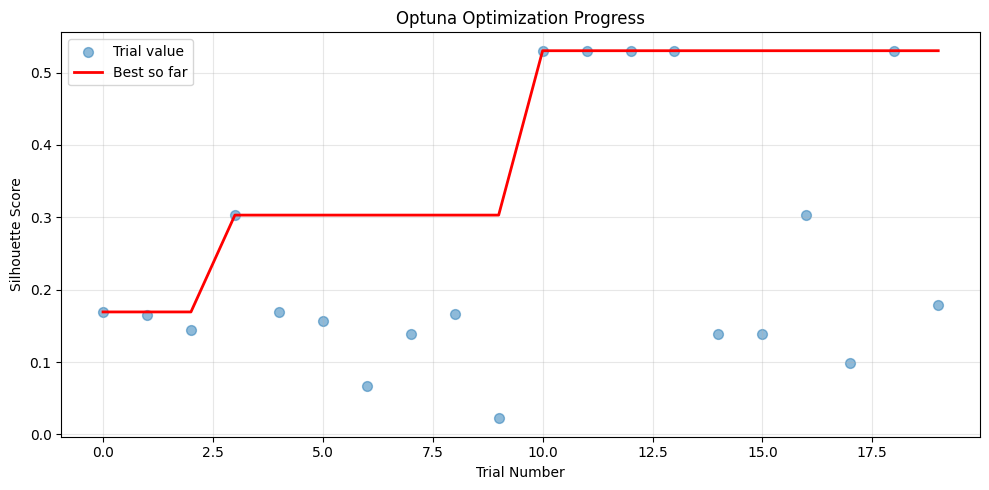

Notice: Optuna quickly finds good values, then converges


In [15]:
# Plot optimization progress
trial_numbers = [t.number for t in study_hac.trials]
trial_values = [t.value if t.value else 0 for t in study_hac.trials]
best_values = [max([v for v in trial_values[:i+1]]) for i in range(len(trial_values))]

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(trial_numbers, trial_values, alpha=0.5, s=50, label='Trial value')
ax.plot(trial_numbers, best_values, 'r-', linewidth=2, label='Best so far')
ax.set_xlabel('Trial Number')
ax.set_ylabel('Silhouette Score')
ax.set_title('Optuna Optimization Progress')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print('Notice: Optuna quickly finds good values, then converges')

## Key Optuna Components

# OPTUNA CONCEPTS

1. STUDY: Container for all optimization results
   study = optuna.create_study(direction="maximize")

2. TRIAL: Single model evaluation with specific hyperparameters
   - Suggested by Optuna sampler
   - Contains hyperparameters and objective value

3. OBJECTIVE FUNCTION: Function Optuna optimizes
   - Returns single numeric value (higher/lower is better)
   - Receives trial object for sampling hyperparameters

4. SAMPLER: Algorithm for sampling hyperparameters
   - TPE (default): Bayesian, learns from past trials
   - Grid: Exhaustive search
   - Random: Random sampling

5. PRUNER: Early stopping strategy
   - Stops unpromising trials early
   - Raises optuna.TrialPruned() to stop

6. BEST TRIAL: Trial with best objective value
   - study.best_trial
   - study.best_params
   - study.best_value

## How to Use Optuna: 4 Steps


# OPTUNA WORKFLOW

* STEP 1: Define objective function

  def objective(trial):

      param1 = trial.suggest_int("param1", 1, 10)
      param2 = trial.suggest_categorical("param2", ["a", "b"])
      model = MyModel(param1=param1, param2=param2)
      score = evaluate(model)
      return score

* STEP 2: Create study
  study = optuna.create_study(direction="maximize")

* STEP 3: Optimize
  study.optimize(objective, n_trials=100)

* STEP 4: Extract best parameters
  best_params = study.best_params
  final_model = MyModel(**best_params)
  predictions = final_model.predict(X_test)

## Hyperparameter Suggestion Methods

#  OPTUNA SUGGESTION METHODS

* Integer parameters:
  trial.suggest_int("n_clusters", 2, 10)
  --> returns integer between 2 and 10

* Float parameters:
  trial.suggest_float("learning_rate", 0.001, 0.1)
  --> returns float between 0.001 and 0.1

* Categorical parameters:
  trial.suggest_categorical("optimizer", ["adam", "sgd"])
  --> returns one of the categories

These suggestions form hyperparameter search space

## Summary: Optuna Benefits

* **Intelligent search** – Learns from past trials

* **Fast convergence** – Finds good parameters quickly

* **Early stopping** – Pruning removes bad trials early

* **Easy to use** – Simple API (study, trial, optimize)

* **Works with any model** – Any objective function

**Next:** Use optimized parameters to train your final model!